**rajvi using steph's code**

In [2]:
from rajvi_mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium
from pyproj import Geod

In [3]:
branches = pd.read_csv('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')

In [4]:
api = MapboxAPI()

In [5]:
branchRadii = gpd.read_file('../data/clean/branches.csv')

branchRadii = branchRadii.set_crs('EPSG:4326')
branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

for i in range(branchRadii.shape[0]):
    api_response =  api.get_data((branchRadii.loc[i,'LATITUDE'],branchRadii.loc[i,'LONGITUDE']), 20)
    branchRadii.loc[i,'geometry'] = shape(api_response)

branchRadii = branchRadii.set_index('BRANCH')
#api_response = api.get_data((branchRadii.loc['Altgeld','LATITUDE'],branchRadii.loc['Altgeld','LONGITUDE']), 20)
#branchRadii.loc['Altgeld','geometry'] = shape(api_response)

/tmp/ipykernel_2001983/3834977753.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_2001983/3834977753.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]


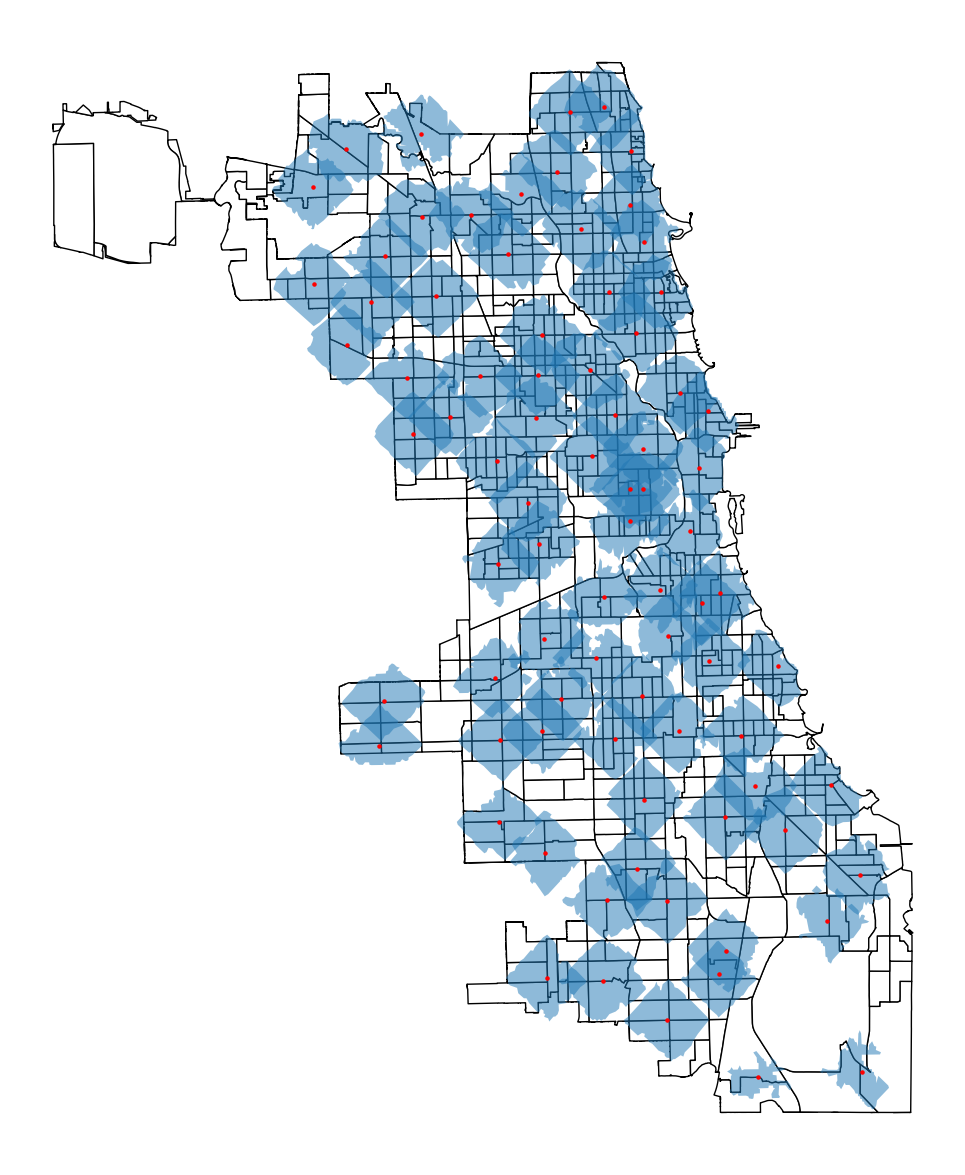

In [6]:
# this line makes a copy of the ageOnly data frame so we can manipulate without affecting our primary dataset
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)', 'current water area (sq. m)', ]]
branchLocsOnly=branches[['BRANCH','LOCATION']]

# the following converts the data frame to a geo data frame and plots estimated percent of retired members of each community
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')
#branchLocsOnly.head()

branchLocsOnly = gpd.GeoDataFrame(
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")
    #branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:32633")

fig, ax = plt.subplots(1, figsize=(15, 15))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

branchRadii.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);


In [18]:
oneLib=pd.DataFrame
oneLib = pd.DataFrame(columns=['Census Tract','geometry'])
areaCalculations = pd.DataFrame(columns=['Census Tract','geometry'])
oneLib.reset_index(inplace = True)

# for loop to make dataframe of overlapping census tracts with the names of each census tract and polygon of area covered
# for loop also adds to new data frame which is collecting the name and geometry of the entire census tract that is partially or fully covered by
# the radius

geod=Geod(ellps='WGS84')
censusAreas = []


for index, row in censusTracts.iterrows():
    #print((branchRadii.intersection(row['geometry']))[0])
    oneBranch = gpd.GeoDataFrame({'geometry': [branchRadii.loc['Canaryville','geometry']]})
    if ((oneBranch.intersection(row['geometry']))[0]).is_empty:
        empty=[]
        empty.append("none")
    else:
        temp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(oneBranch.intersection(row['geometry'])[0])]}, index=[0])
        oneLib=pd.concat([oneLib,temp])
        geomTemp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(row['geometry'])]})
        areaCalculations = pd.concat([areaCalculations, geomTemp])


for index, row in areaCalculations.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area / -10**6
    censusAreas.append(poly_area)
    
areaCalculations['calculated area'] = censusAreas
areaCalculations.reset_index(inplace = True)

/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersectio

In [19]:
areaCalculations

,index,Census Tract,geometry,calculated area
0,0,17031612200,"POLYGON ((-87.659863 41.808672, -87.659138 41....",0.898083
1,0,17031843800,"POLYGON ((-87.645416 41.80886, -87.645296 41.8...",1.309514
2,0,17031835600,"POLYGON ((-87.635774 41.809047, -87.635725 41....",0.917501
3,0,17031610800,"POLYGON ((-87.641173 41.816259, -87.640944 41....",0.332498
4,0,17031844600,"POLYGON ((-87.628928 41.816453, -87.628494 41....",0.434671
5,0,17031842600,"POLYGON ((-87.665369 41.823151, -87.664798 41....",3.679425
6,0,17031835500,"POLYGON ((-87.636165 41.823585, -87.636118 41....",0.914015
7,0,17031380600,"POLYGON ((-87.62931 41.823677, -87.629279 41.8...",0.838894
8,0,17031839900,"POLYGON ((-87.65773 41.826085, -87.657729 41.8...",1.167221
9,0,17031340600,"POLYGON ((-87.636251 41.830881, -87.636226 41....",0.496576


In [20]:

# convert oneLib to geodata frame and reasssign to crs used for area calculations (by default, its 4326 geometries)
oneLib = gpd.GeoDataFrame(oneLib, geometry="geometry")
oneLib = oneLib.set_crs(crs = 'epsg:4326')

oneLib.reset_index(inplace = True)

geod=Geod(ellps='WGS84')

overlappingAreas = []

for index, row in oneLib.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area / -10**6
    overlappingAreas.append(poly_area)

oneLib['Area Within Radius']= overlappingAreas
oneLib['census Area'] = areaCalculations['calculated area']

# using Geod method with WGS84 and espg:4326 gives us area in DEGREES not meters so the proportion is accurate but 
# the actual area values you have to convert to a different crs to be useful as distances



In [21]:
print(oneLib.crs)

epsg:4326


In [22]:
oneLib = oneLib.drop(columns='level_0')
oneLib['Percent Overlap'] = oneLib['Area Within Radius']/oneLib['census Area']

In [23]:
oneLib = oneLib.drop(columns='index')
oneLib

,Census Tract,geometry,Area Within Radius,census Area,Percent Overlap
0,17031612200,"POLYGON ((-87.64557 41.80302, -87.64690 41.804...",0.112870,0.898083,0.125679
1,17031843800,"POLYGON ((-87.63657 41.80574, -87.63757 41.808...",0.419545,1.309514,0.320382
2,17031835600,"POLYGON ((-87.63232 41.80810, -87.63457 41.806...",0.059256,0.917501,0.064584
3,17031610800,"POLYGON ((-87.64094 41.81626, -87.64087 41.816...",0.332498,0.332498,1.000000
4,17031844600,"POLYGON ((-87.62219 41.81634, -87.62557 41.813...",0.171525,0.434671,0.394610
5,17031842600,"POLYGON ((-87.65327 41.80834, -87.65329 41.809...",2.382602,3.679425,0.647548
6,17031835500,"POLYGON ((-87.62957 41.81085, -87.63015 41.811...",0.823628,0.914015,0.901110
7,17031380600,"POLYGON ((-87.62264 41.81734, -87.62228 41.816...",0.194898,0.838894,0.232327
8,17031839900,"POLYGON ((-87.64157 41.83049, -87.63999 41.829...",0.639572,1.167221,0.547944
9,17031340600,"POLYGON ((-87.63557 41.82681, -87.63457 41.825...",0.087109,0.496576,0.175420


In [24]:
altgeldCensusOverlap20Walking1 = oneLib.copy(deep=True)
#altgeldCensusOverlap20Walking1.to_csv('../individual lib census/altgeldCensusOverlap20Walking1.csv')

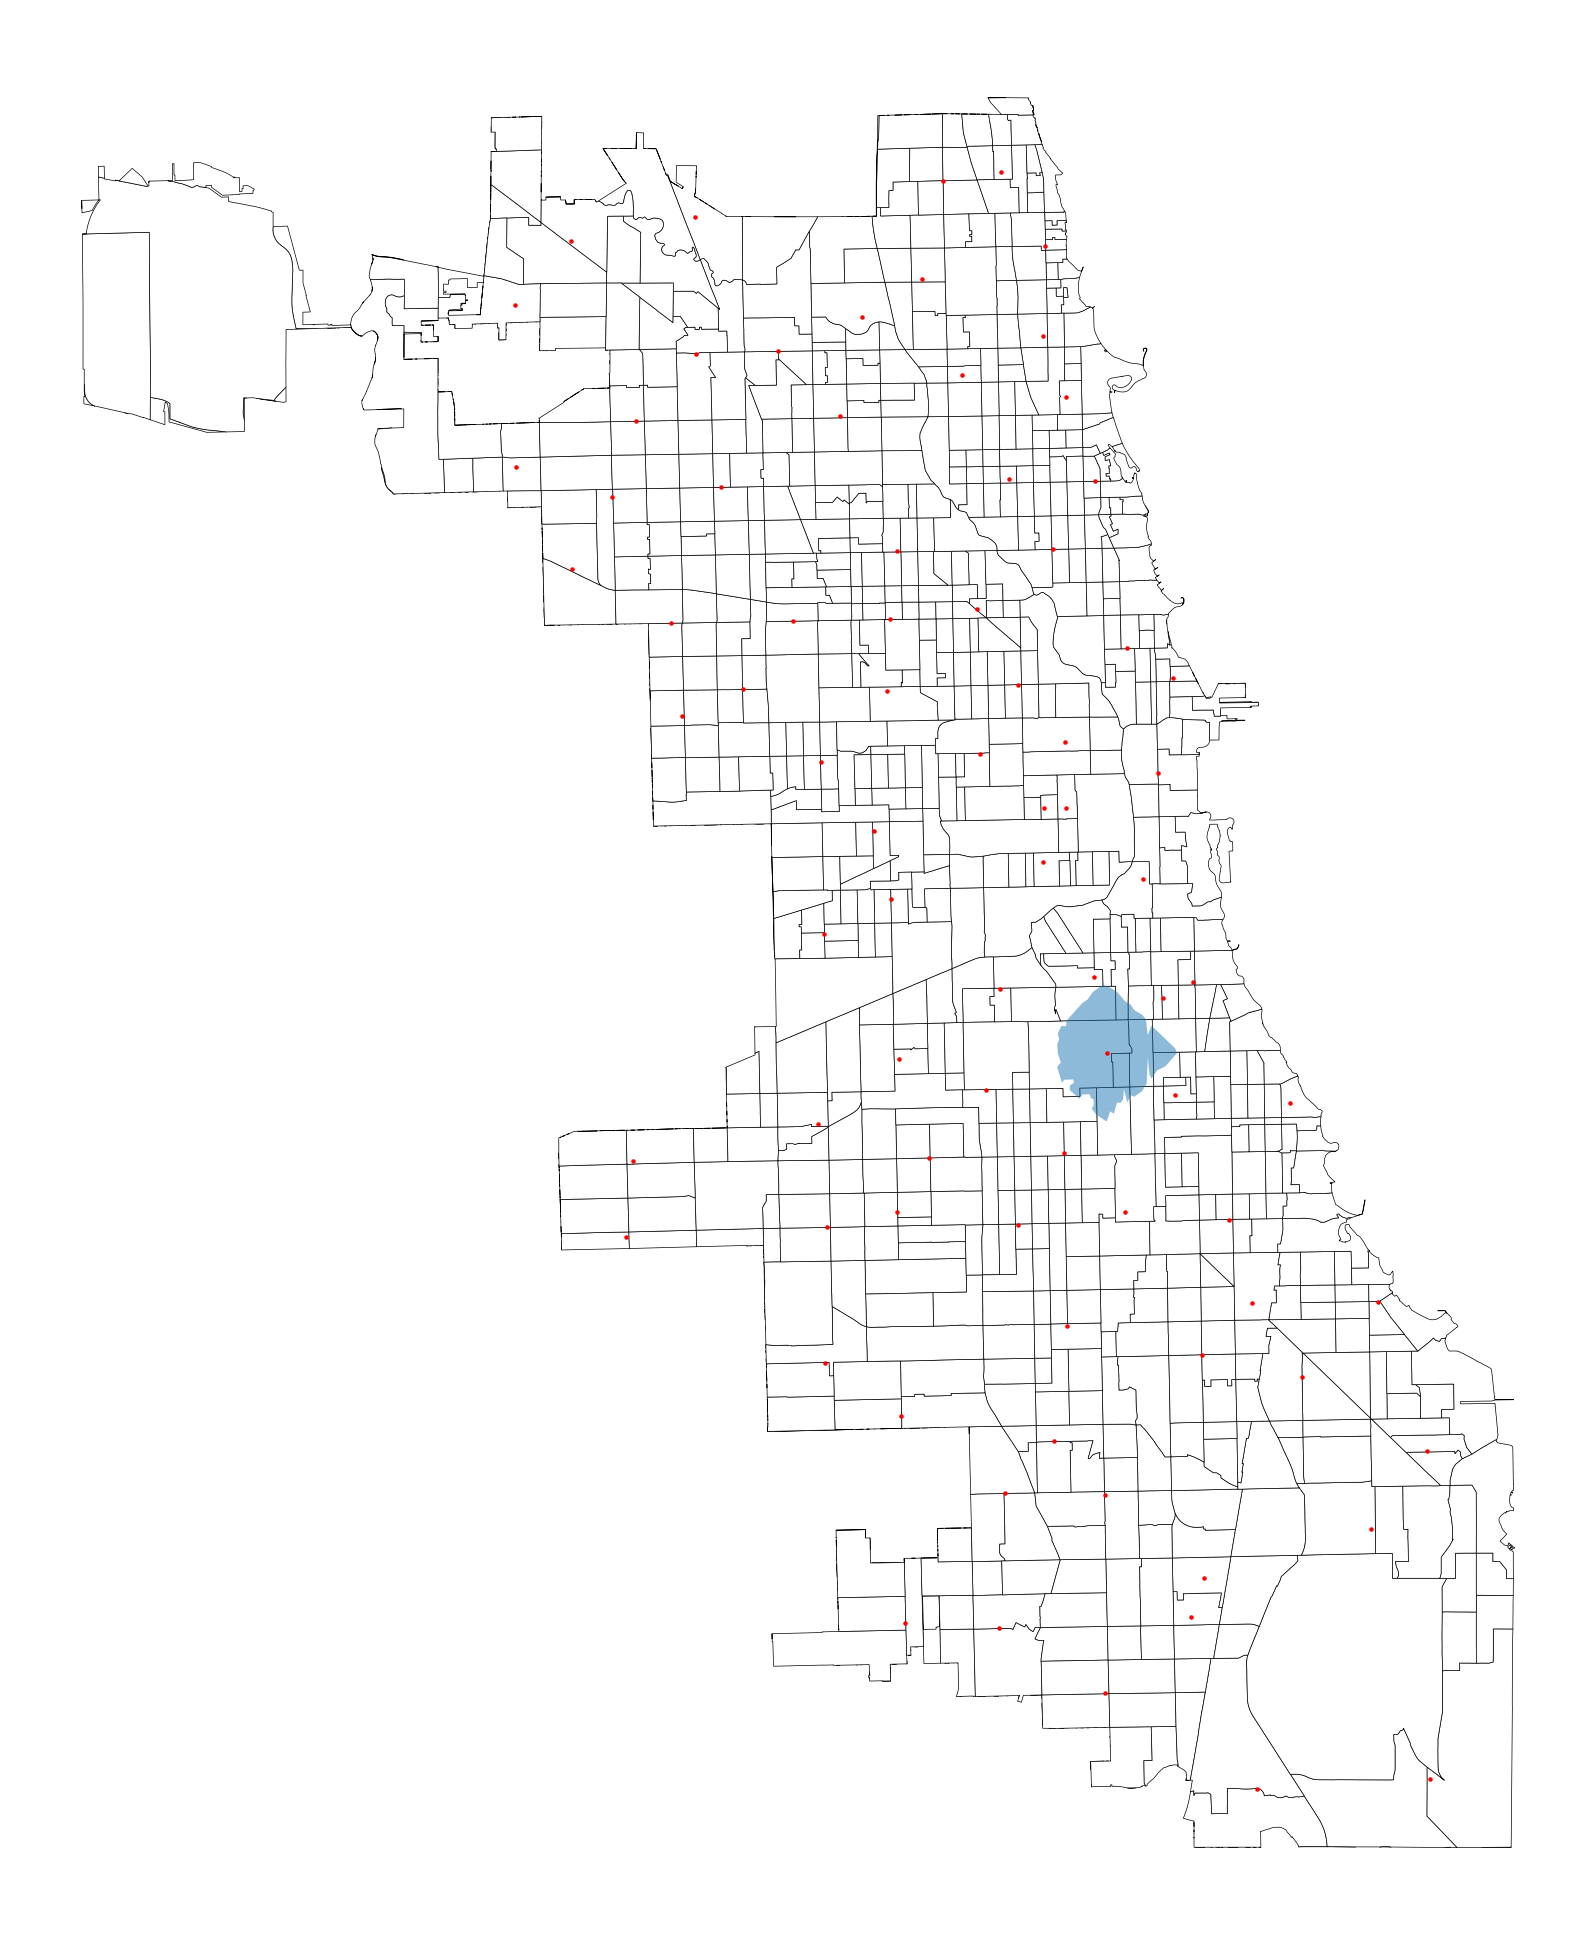

In [25]:
fig, ax = plt.subplots(1, figsize=(25, 25))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black', linewidth=.5)
ax.axis('off')

altgeldCensusOverlap20Walking1.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

